In [152]:
#from numba import jit, cuda
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from random import gauss
%matplotlib inline

## Step 1: Generate Questions and Students
<ol>
    <li>Number of Student = S</li>
    <li>Number of Questions = C</li>
    <li>Number of Skills = K</li>
</ol>

In [153]:
# HYPERPARAMETERS
S = 50      # students
C = 10000   # questions
K = 10      # skills

(20000, 10)

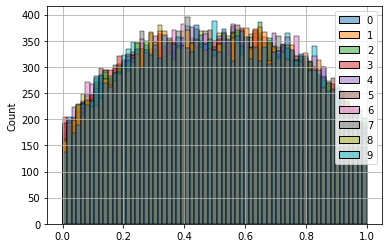

In [154]:
# APPROACH 1 -- Generate Students and Questions as independent variables
lower, upper = 0, 1
s_mu, s_sigma = 0.25, 0.15  # Mean in 0.25 since assumed low initial skills level
q_mu1, q_sigma1 = 0.25, 0.25
q_mu2, q_sigma2 = 0.75, 0.25
students = stats.truncnorm.rvs((lower-s_mu)/s_sigma,(upper-s_mu)/s_sigma,loc=s_mu,scale=s_sigma,size=(S,K))
questions = stats.truncnorm.rvs((lower-q_mu1)/q_sigma1,(upper-q_mu1)/q_sigma1,loc=q_mu1,scale=q_sigma1,size=(C,K))
questions = np.append(questions, stats.truncnorm.rvs((lower-q_mu2)/q_sigma2,(upper-q_mu2)/q_sigma2,loc=q_mu2,scale=q_sigma2,size=(C,K))).reshape(-1,K)
#questions = np.random.uniform(size=(C,K))
student_norms = np.linalg.norm(students, axis=1)
question_norms = np.linalg.norm(questions, axis=1)
sns.histplot(questions)

questions.shape

In [155]:
# # APPROACH 2 -- Generate Performance Matrix Y (S x C) and use MF to find students, questions
# lower, upper = 0, 1
# p_mu, p_sigma = 0.5, 0.20
# performance = stats.truncnorm.rvs((lower-p_mu)/p_sigma,(upper-p_mu)/p_sigma,loc=p_mu,scale=p_sigma,size=(S,C))
# #number_of_nan = 12500 # Half of the students
# #performance.ravel()[np.random.choice(performance.size, number_of_nan, replace=False)] = np.nan
# sns.heatmap(performance)
# # Matrix Factorization
# from sklearn.decomposition import NMF
# model = NMF(n_components=K, random_state=42, max_iter=10000)
# students = model.fit_transform(performance)
# questions = np.transpose(model.components_)

## For the time being better use approach 1
## Step 2: Model definition

In [156]:
import do_mpc
model_type = 'discrete'
model = do_mpc.model.Model(model_type)
# States
x = model.set_variable(var_type='_x', var_name='x', shape=(K,1))
z = model.set_variable(var_type='_z', var_name='z', shape=(K,1))
#z2 = model.set_variable(var_type='_z', var_name='z2', shape=(1,1))
# Inputs
u = model.set_variable(var_type='_u', var_name='u', shape=(K,1))
# Outputs
#y = model.set_meas('y', shape=(1,1))

### Model parameters
Student knowledge $\varphi^t \in \mathbb{S := R}^K$, where $\mathbb{S}$ is the student space containing $S$ students,
and $K$ is the number of skills involved.

Skill requirements $\psi_j \in \mathbb{C := R}^K$, representing the $K$ skill-levels required to solve task $j$,
sampled from the task space, $\mathbb{C}$.



### Model dynamics

Estimated student performance, given knowledge $\varphi$ and content requirements $\psi$ :

$\tilde{y} = \max(1 - \frac{||\alpha^{i,j}||}{||\varphi_i||}, 0)$

where $\varphi_i$ is student $i$'s knowledge in each skill,
and $\alpha^{i,j}$ represents their skill deficiency in each skill $k$ wrt. content requirement $j$,
such that

$\alpha^{i,j} = [\alpha^{i,j}_0, ..., \alpha^{i,j}_K]$,
and

$\alpha^{i,j}_k = \psi_{jk} \max(1 - \frac{\varphi_{ik}}{\psi_{jk}}, 0)$,

restricts the knowledge improvement to the Proximal Development Zone (Vygotsky, 1978),
where the task difficulty must be greater than, but close to,
the student's current skill-level to improve their knowledge.
Additionally, there's no learning if the skill requirements are "beyond" the student's knowledge level:
$||\psi_j|| \leq 2*||\varphi_i||$

Specifically, learning happens when $(||\varphi_i - \psi_j|| > 0) \land (||\psi_j|| \leq 2*||\varphi_i||)$


The update rule for $\varphi$ is defined through $\tau : \mathbb{S \times C \rightarrow S}$ :

$\tau(\varphi_i, \psi_j)_k = \tilde{y}(\varphi_{i,k}, \psi_{j,k}) * \gamma * \delta(\alpha_{k}^{i,j} > 0) * \psi_{j,k}$,

where $\gamma$ is a scalar weight. Here, $\delta$ is (wrongly described as)
the Kronecker $\delta$ equal to 1 when the condition is true, and 0 otherwise.
This function is better described using a generalization of the Kronecker $\delta$, namely the *Iverson bracket*:

$[P] = \begin{cases} 1, \text{if } P \text{ is true} \\
                     0, \text{otherwise}
       \end{cases}$,

such that

$\tau(\varphi_i, \psi_j)_k = \tilde{y}(\varphi_{i,k}, \psi_{j,k}) * \gamma * [\alpha_{k}^{i,j} > 0] * \psi_{j,k}$.


In [157]:
# def gaussian(x, mu, sig):
#     return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
# x = np.arange(0,1.05,0.05)
# y = gaussian(x, 0.5, 0.1)
# plt.plot(x,y)

In [158]:
def circ(x):
    return 1- sqrt(1 - (x-1)**2)
def gaussian(x, mu, sig):
    return exp(-((x - mu)**2) / (2 * (sig**2)))

def perturbate():
    val = np.random.normal(1, 0.4)
    val = 2 - val if val > 1 else val
    return val

In [159]:
from casadi import *
#x_next = SX()
rhs = []

gamma = 0.8 # Learning rate

alpha = []
y_tilde = []

for k in range(K):
    # i: student
    # j: content
    # k: skill

    u_k = u[k]  #
    x_k = x[k]

    print("For skill {}, x_ik = {}, and u_jk = {}".format(k, x_k, u_k))
    #print("For skill {}, model data[\'_x\']={}".format(k, vars(model)))

    # alpha: skill deficiency (for all k) of student_i, given knowledge_i and content_j (requirement)
    ## alpha is zero when x_ik > u_jk, between (0,1] otherwise
    #alpha = u_jk * fmax(1 - (x_ik / u_jk), 0)
    alpha_k = fmax(1 - x_k/u_k,0) * u_k # Between 0 and 1
    #alpha_k = gaussian(fmax(u_k - x_k,0), 0.5, 0.1)
    #print(alpha_k)
    #y_tilde_k = circ(alpha_k)
    #y_tilde_k = 1 - alpha_k
    #y_tilde_k = fmax(1 - alpha_k/x_k, 0)
    alpha.append(alpha_k)
    y_tilde_k = gaussian(alpha_k, (1-x_k)/2, (1-x_k)/5) * perturbate()
    y_tilde.append(y_tilde_k)

# Deficiency and skill norms for estimated performance calculation
#alpha_norm = norm_2(vertcat(*alpha))   # but before alpha was a number, you need to do it outside the loop at the end
#phi_norm = norm_2(x) # same            

# Estimated performance
performance = sum1(vertcat(*y_tilde))/K

for k in range(K):
    u_k = u[k]  #
    x_k = x[k]
    # Knowledge update term
    tau_k   =  performance * alpha[k]# * (alpha[k] > 0)#y_tilde  * u_k
    #tau_k = y_tilde * gaussian(alpha[k], 0.5, 0.1) * gamma
    #scalar = scalar * scalar * integer_boolean * scalar

    # Append rule to list of right-hand-side equations
    rhs.append(x_k + tau_k)

x_next = vertcat(*rhs)
model.set_rhs('x', x_next)

For skill 0, x_ik = x_0, and u_jk = u_0
For skill 1, x_ik = x_1, and u_jk = u_1
For skill 2, x_ik = x_2, and u_jk = u_2
For skill 3, x_ik = x_3, and u_jk = u_3
For skill 4, x_ik = x_4, and u_jk = u_4
For skill 5, x_ik = x_5, and u_jk = u_5
For skill 6, x_ik = x_6, and u_jk = u_6
For skill 7, x_ik = x_7, and u_jk = u_7
For skill 8, x_ik = x_8, and u_jk = u_8
For skill 9, x_ik = x_9, and u_jk = u_9


In [160]:
model.set_expression(expr_name='cost_x', expr=sum1(x**2))
model.set_expression(expr_name='alpha', expr=fmax(u - x,0))
#model.set_expression(expr_name='y_tilde', expr=circ(fmax(u - x,0)))
#model.set_expression(expr_name='y_tilde_tot', expr=sum1(vertcat(*y_tilde))/K)
#model.set_expression(expr_name='z', expr=u-x)
#model.set_expression(expr_name='cost_x', expr=sum1(fabs(x)))
#model.set_expression(expr_name='cost_u', expr=sum1(fabs(u)))
#model.set_expression(expr_name='z', expr=z-(u-x)) #z-sum1(u-x))
model.set_alg(expr_name='z', expr=z-(u-x))
#model.set_alg(expr_name='z_upper', expr=sum1(u-x)>0)

In [161]:
model.setup()

In [162]:
mpc=do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 5,
    't_step': 1,
    'n_robust': 0,
    'state_discretization': 'discrete',
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [163]:
lterm = -1*model.aux['cost_x']
mterm = -1*model.aux['cost_x']
mpc.set_objective(mterm=mterm, lterm=lterm)
#mpc.set_rterm(u=0)

In [164]:
# Lower bounds on states:
mpc.bounds['lower','_x', 'x'] = 0

# Upper bounds on states
mpc.bounds['upper','_x', 'x'] = 1

# Lower bounds on skill deficiency:
mpc.bounds['lower','_z', 'z'] = 0
# # # # Upper bounds on skill deficiency:
mpc.bounds['upper','_z', 'z'] = 0.15

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'u'] = 0
# Upper bounds on inputs:
mpc.bounds['upper','_u', 'u'] = 1

In [165]:
mpc.setup()


C:\Users\Thomas\anaconda3\envs\LearningAnalytics\lib\site-packages\do_mpc\controller.py:760: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [166]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=1)

In [167]:
simulator.setup()


In [168]:
estimator = do_mpc.estimator.StateFeedback(model)
x0 = students[4]
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
mpc.set_initial_guess()


In [169]:
from helper_funcs.distance_metrics import Similarity

# TODO: Make it so that a question can only be asked once.
# Need: SxC boolean masking matrix. Init False, flip entries to True as questions are being asked.
#q_tracker = np.zeros(questions.shape, dtype=bool)
q_tracker = np.zeros(questions.shape, dtype=int)
def question_selector(u_tilde):
    # Library of different similarity metrics to explore
    similarity_metrics = Similarity(minimum=1e-20)

    # Keeping track of best match and its distance to the optimal input
    min_diff = np.inf
    best_match = None
    best_match_idx = None

    # Brute force find the best matching question to the optimal one.
    for idx, q in enumerate(questions):
        '''
            On the Surprising Behavior of Distance Metrics in High Dimensional Space
            https://bib.dbvis.de/uploadedFiles/155.pdf
        '''
        # Calculate the question's similarity to the optimal solution:
        q_diff = similarity_metrics.fractional_distance(q, u_tilde, fraction=0.5)
        #q_diff = similarity_metrics.euclidean_distance(q, u_tilde)

        # Hold on to the temporary best match
        if q_diff < min_diff: # and not q_tracker[0,i]:
            min_diff = q_diff
            best_match = q
            best_match_idx = idx

    # Make this question "spent":
    #q_tracker[best_match_idx, 0] = True
    q_tracker[best_match_idx, 0] += 1

    return best_match.reshape(u_tilde.shape)

In [170]:
%%capture
for i in range(50):
    u_tilde = mpc.make_step(x0)
    u = question_selector(u_tilde)
    y_next = simulator.make_step(u)
    x0 = estimator.make_step(y_next)

In [171]:
#print(sum(q_tracker[q_tracker == True]), "of", sum(~q_tracker[~q_tracker == True]), "questions spent")
print(sum(q_tracker[q_tracker > 0]), "questions asked \n\t", q_tracker[q_tracker > 1].shape, "questions repeated \n\r", np.max(q_tracker), "most popular question")

50 questions asked 
	 (3,) questions repeated 
 42 most popular question


In [172]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

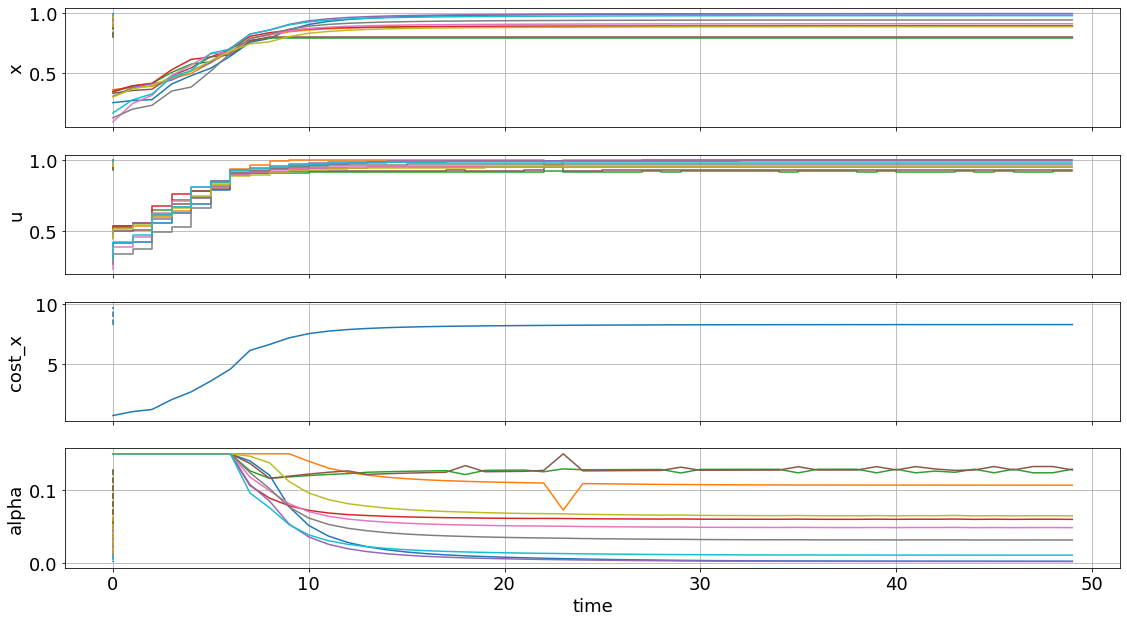

In [173]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.reset_axes()
graphics.plot_results()
plt.show()
